# Hodgkin-Huxley Model

## Model Overview

Hodgkin-Huxley model was proposed by Hodgkin and Huxley in 1952. This model provides a mathematical description of the initiation and propagation of the action potentials in neurons.

The ionic mechanisms are described by an electrical circuit:

<img src="../../images/HH-circuit.png">

The lipid bilayer of the membrane is represented as a capacitance ($C$). Resistors, $R_{Na}$, $R_K$ and $R$ represent sodium, potassium and unspecific ion channels, respectively. The batteries ($E_{Na}, E_K, E_L$) represent ion reversal potentials based on the ion concentration difference. The reversal potentials can be calculated from the Nernst equations. $E_{Na}$, $E_{K}$, and $E_{L}$ under $37^\circ \rm C$ are around $+50$mV, $-77$mV, and $-54.387$mV, respectively.

In [1]:
# constant values
E_NA = 50.
E_K = -77.
E_LEAK = -54.387
C = 1.0
V_THRESHOLD = 20.

## BrainPy Implementation

In [2]:
import brainpy as bp
import brainpy.numpy as np

We'll define the neuron states using an `NeuState` object named "ST" to define all variables and set default values.

In [3]:
# define variables and initial values
ST = bp.types.NeuState({'V': -65., 
       'm': 0.05, 'h': 0.60, 'n': 0.32, 'spike': 0., 'input': 0.},
       help='Hodgkin–Huxley neuron state.\n'
              '"V" denotes membrane potential.\n'
              '"n" denotes potassium channel activation probability.\n'
              '"m" denotes sodium channel activation probability.\n'
              '"h" denotes sodium channel inactivation probability.\n'
              '"spike" denotes spiking state.\n'
              '"input" denotes synaptic input.\n'
)

### Dynamics of membrane potential

Let's take a look at the mathematical expression of the model dynamics. We know from the electrical circuit:

$$ C \frac {dV} {dt} = -(I_{Na} + I_{K} + I_{leak}) + I(t) $$

that is: 

$$ C \frac {dV} {dt} = - \sum_k I_{ion, k} + I(t) $$


Using Ohm's law (I=gV), we get:

$$ I_x = g_x (V - E_x) , \quad x\in \{Na, K, leak \} $$

where $x$ is a specific ion channel.

Experiments suggest that $g_{Na}$ and $g_K$ are functions of time and membrane potential, reflecting the change of permeability.

The formal assumptions used to describe the sodium and potassium conductances are:

$$ g_{Na} = \bar{g}_{Na} m^3 h,   \qquad  m, h \in [ 0, 1 ]$$ 

$$ g_K = \bar{g}_K n^4,   \qquad  n \in [ 0, 1 ] $$

where $\bar{g}_{Na}$ and $\bar{g}_{K}$ are constants representing the maximum conductances. $m$ and $h$ are dimensionless variables indicating the state of sodium channels, and $n$ represents the state of potassium channels. In other words, $x=1$ means the channel is open and $x=0$ corresponds to the channel being closed.

In [4]:
# constant values
G_NA = 120.
G_K = 36.
G_LEAK = 0.03

In [5]:
@bp.integrate
def dVdt(V, t, m, h, n, input_current):
    I_Na = (g_Na * np.power(m, 3.0) * h) * (V - E_Na)
    I_K = (g_K * np.power(n, 4.0))* (V - E_K)
    I_leak = g_leak * (V - E_K)
    dvdt = (- I_Na - I_K - I_leak + input_current)/C 
    return dvdt, noise / C

In BrainPy, you can just write down the right side of the differential equation, and use a decorator `@bp.integrate` before the function definition. This decorator will provide a numerical integrate method to solve the differential equation. (It will use Euler's method by default)

### Dynamics of ionic channels

The dynamics of gating variables are given by:

$$ \begin{eqnarray*}
\frac {dx} {dt} & = & - \frac {x - x_0(V)} {\tau_x (V)}
\\
& = & \alpha_x (1-x)  - \beta_x x 
\end{eqnarray*}$$ 

where $x$ can be $m, n, h$, and $\alpha$ and $\beta$ are rate constants.

The functions $\alpha$ and $\beta$ are given by:

$$ \alpha_m(V) = \frac {0.1(V+40)}{1-exp(\frac{-(V + 40)} {10})} \qquad
\beta_m(V) = 4.0 exp(\frac{-(V + 65)} {18}) $$


$$ \alpha_h(V) = 0.07 exp(\frac{-(V+65)}{20}) \qquad
\beta_h(V) = \frac 1 {1 + exp(\frac{-(V + 35)} {10})} $$


$$ \alpha_n(V) = \frac {0.01(V+55)}{1-exp(-(V+55)/10)}  \qquad
\beta_n(V) = 0.125 exp(\frac{-(V + 65)} {80}) $$

In [6]:
@bp.integrate
def dmdt(m, t, V):
    alpha = 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
    beta = 4.0 * np.exp(-(V + 65) / 18)
    return alpha * (1 - m) - beta * m

@bp.integrate
def dhdt(h, t, V):
    alpha = 0.07 * np.exp(-(V + 65) / 20.)
    beta = 1 / (1 + np.exp(-(V + 35) / 10))
    return alpha * (1 - h) - beta * h

@bp.integrate
def dndt(n, t, V):
    alpha = 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
    beta = 0.125 * np.exp(-(V + 65) / 80)
    return alpha * (1 - n) - beta * n

Let's specify the update rules for variable states with an <code>update</code> function (You can also use multiple update functions).

In [7]:
def update(ST, _t_):
    m = np.clip(dmdt(ST['m'], _t_, ST['V']), 0., 1.) # use np.clip to limit the dmdt to between 0 and 1.
    h = np.clip(dhdt(ST['h'], _t_, ST['V']), 0., 1.)
    n = np.clip(dndt(ST['n'], _t_, ST['V']), 0., 1.)
    V = dVdt(ST['V'], _t_, m, h, n, ST['input'])  # solve V from dVdt equation.
    spike = np.logical_and(ST['V'] < V_threshold, V >= V_threshold) # spike when reach threshold.
    ST['spike'] = spike
    ST['V'] = V
    ST['m'] = m
    ST['h'] = h
    ST['n'] = n
    ST['input'] = 0.

### Define model (real code)

Now we can define a HH model by combining all the example codes above and returning a `NeuType` object.

In [8]:
# constant values
E_NA = 50.
E_K = -77.
E_LEAK = -54.387
C = 1.0
G_NA = 120.
G_K = 36.
G_LEAK = 0.03
V_THRESHOLD = 20.

def define_HH (noise=0., V_threshold = V_THRESHOLD, C = C, E_Na = E_NA, E_K = E_K,
             E_leak = E_LEAK, g_Na = G_NA, g_K = G_K, g_leak = G_LEAK):
    '''
    The Hodgkin–Huxley neuron model.
    
    Args:
        noise (float): the noise fluctuation. default = 0.
        V_threshold (float): the spike threshold. default = 20. (mV)
        C (float): capacitance. default = 1.0 (ufarad)
        E_Na (float): reversal potential of sodium. default = 50. (mV)
        E_K (float): reversal potential of potassium. default = -77. (mV)
        E_leak (float): reversal potential of unspecific. default = -54.387 (mV)
        g_Na (float): conductance of sodium channel. default = 120. (msiemens)
        g_K (float): conductance of potassium channel. default = 36. (msiemens)
        g_leak (float): conductance of unspecific channels. default = 0.03 (msiemens)
        
    Returns:
        HH_neuron (NeuType).
        
    '''
    
    # define variables and initial values
    ST = bp.types.NeuState(
        {'V': -65., 'm': 0.05, 'h': 0.60, 'n': 0.32, 'spike': 0., 'input': 0.},
        help='Hodgkin–Huxley neuron state.\n'
             '"V" denotes membrane potential.\n'
             '"n" denotes potassium channel activation probability.\n'
             '"m" denotes sodium channel activation probability.\n'
             '"h" denotes sodium channel inactivation probability.\n'
             '"spike" denotes spiking state.\n'
             '"input" denotes synaptic input.\n'
    )
    
    
    # call bp.integrate to solve the differential equations
    
    @bp.integrate
    def dmdt(m, t, V):
        alpha = 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
        beta = 4.0 * np.exp(-(V + 65) / 18)
        return alpha * (1 - m) - beta * m
    
    @bp.integrate
    def dhdt(h, t, V):
        alpha = 0.07 * np.exp(-(V + 65) / 20.)
        beta = 1 / (1 + np.exp(-(V + 35) / 10))
        return alpha * (1 - h) - beta * h
    
    @bp.integrate
    def dndt(n, t, V):
        alpha = 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
        beta = 0.125 * np.exp(-(V + 65) / 80)
        return alpha * (1 - n) - beta * n
    
    @bp.integrate
    def dVdt(V, t, m, h, n, input_current):
        I_Na = (g_Na * np.power(m, 3.0) * h) * (V - E_Na)
        I_K = (g_K * np.power(n, 4.0))* (V - E_K)
        I_leak = g_leak * (V - E_K)
        dvdt = (- I_Na - I_K - I_leak + input_current)/C 
        return dvdt, noise / C
    
    # update the variables change over time (for each step)
    def update(ST, _t_):
        m = np.clip(dmdt(ST['m'], _t_, ST['V']), 0., 1.) # use np.clip to limit the dmdt to between 0 and 1.
        h = np.clip(dhdt(ST['h'], _t_, ST['V']), 0., 1.)
        n = np.clip(dndt(ST['n'], _t_, ST['V']), 0., 1.)
        V = dVdt(ST['V'], _t_, m, h, n, ST['input'])  # solve V from dVdt equation.
        spike = np.logical_and(ST['V'] < V_threshold, V >= V_threshold) # spike when reach threshold.
        ST['spike'] = spike
        ST['V'] = V
        ST['m'] = m
        ST['h'] = h
        ST['n'] = n
        ST['input'] = 0.   
    
    return bp.NeuType(name='HH_neuron', requires={"ST": ST}, steps=update, vector_based=True)

### Simulation

You can use `bp.profile.set` to make global settings such as backend, numerical methods, etc.

In [9]:
# use "profile" to make global settings.
bp.profile.set(backend='numpy', dt=0.02, numerical_method='milstein', merge_steps=True)

Create neurons.

In [10]:
HH_geometry = (100,)

# set initial g_K (between 35 and 37)
g_K = np.random.random(HH_geometry) * 2 + 35

# create HH neuron
HH = define_HH(noise = 1., g_K = g_K)

neuron = bp.NeuGroup(HH, geometry=HH_geometry, 
                     monitors=['spike', 'V', 'm', 'h', 'n'])

# set initial variable state
neuron.ST['V'] = np.random.random(HH_geometry) * 20 + -75

Note that under `numpy` mode, parameters can only be initialized while creating the neuron (`HH = define_HH(noise = 1., g_K = g_K)`). While under `numba` mode, you can update parameter like setting the variable state by using `neuron.par['g_K'] = g_K`.

We can generate a step current by using `bp.inputs.constant_current`.

In [11]:
# step current parameters
amplitude = 6.9  # step current amplitude
stim_start = 10. # stimulation start point
stim_t = 50.   # stimulation duration
post_stim_t = 20. # after stimulation time

# generate step current
I = [(0, stim_start), (amplitude, stim_t), (0, post_stim_t)]
(step_I, duration) = bp.inputs.constant_current(I)

# apply input current to the neuron
neuron.run(duration=duration, inputs=['ST.input', step_I], report=True)

Compilation used 0.0005 ms.
Start running ...
Run 10.0% used 0.158 s.
Run 20.0% used 0.298 s.
Run 30.0% used 0.411 s.
Run 40.0% used 0.578 s.
Run 50.0% used 0.726 s.
Run 60.0% used 0.882 s.
Run 70.0% used 1.013 s.
Run 80.0% used 1.151 s.
Run 90.0% used 1.278 s.
Run 100.0% used 1.415 s.
Simulation is done in 1.416 s.


## Model Visualization

### Dynamics of membrane potential

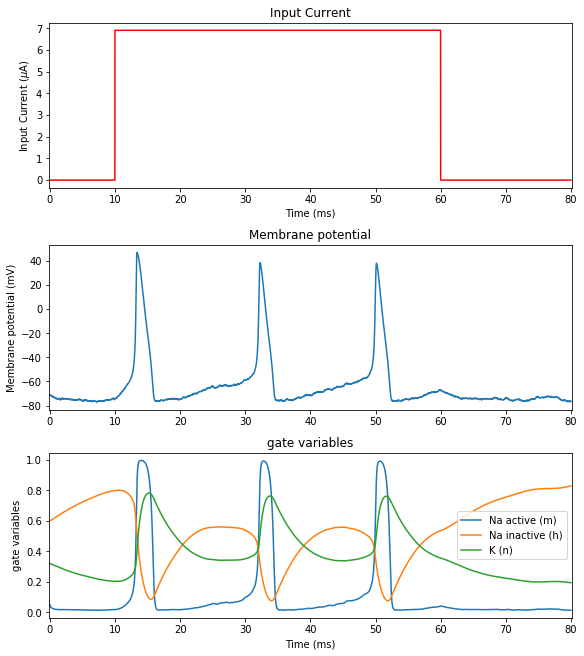

In [12]:
import matplotlib.pyplot as plt

# read time sequence
ts = neuron.mon.ts
fig, gs = bp.visualize.get_figure(3, 1, 3, 8)

# plot input current
fig.add_subplot(gs[0, 0])
plt.plot(ts, step_I, 'r')
plt.ylabel('Input Current ($\mu$A)')
plt.xlim(-0.1, duration + 0.1)
plt.xlabel('Time (ms)')
plt.title('Input Current')

# plot membrane potential
fig.add_subplot(gs[1, 0])
plt.plot(ts, neuron.mon.V[:, 0])
plt.ylabel('Membrane potential (mV)')
plt.xlim(-0.1, duration + 0.1)
plt.title('Membrane potential')

# plot gate variables
fig.add_subplot(gs[2, 0])
plt.plot(ts, neuron.mon.m[:, 0], label='Na active (m)')
plt.plot(ts, neuron.mon.h[:, 0], label='Na inactive (h)')
plt.plot(ts, neuron.mon.n[:, 0], label='K (n)')
plt.legend()
plt.xlim(-0.1, duration + 0.1)
plt.xlabel('Time (ms)')
plt.ylabel('gate variables')
plt.title('gate variables')

plt.show()

We can see from the graphs that the results corresponse to neuro-phisiological recordings. We can see depolarization, repolarization and hyperpolarization stages from the simulated action potential.

The graph of gate variables demonstrate that $m$ increased during depolarization, which indicates the opening of $Na^+$ channels ($Na^+$ influx). While $n$ reached it's peak during repolarization stage, which reflects the opening of $K^+$ channels ($K^+$ efflux). The raise of $h$ and drop of $Na$ during repolarization result in the closing of $Na^+$ channels.

### Channel currents and conductances

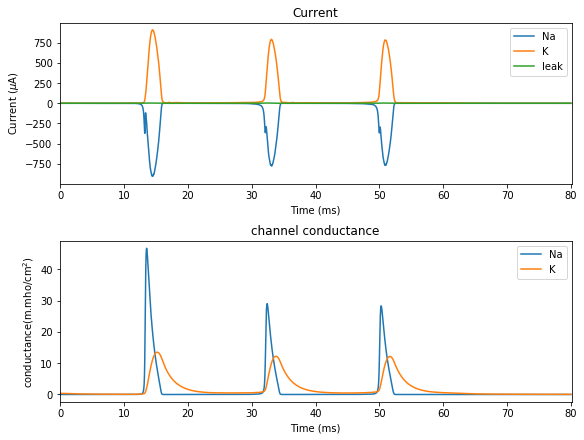

In [13]:
# conductances of ion channels
g_Na = G_NA * np.power(neuron.mon.m[:, 0], 3.0) * neuron.mon.h[:, 0]
g_K = G_K * np.power(neuron.mon.n[:, 0], 4.0)

V = neuron.mon.V[:, 0]

I_Na = g_Na * (V - E_NA)
I_K = g_K * (V - E_K)
I_leak = G_LEAK * (V - E_K)

fig, gs = bp.visualize.get_figure(2, 1, 3, 8)

# plot input current
fig.add_subplot(gs[0, 0])
plt.plot(ts, I_Na, label = 'Na')
plt.plot(ts, I_K, label = 'K')
plt.plot(ts, I_leak, label = 'leak')
plt.legend()
plt.ylabel('Current ($\mu$A)')
plt.xlim(-0.1, duration + 0.1)
plt.xlabel('Time (ms)')
plt.title('Current')

# plot gate variables
fig.add_subplot(gs[1, 0])
#plt.plot(ts, V, label='V')
plt.plot(ts, g_Na, label='Na')
plt.plot(ts, g_K, label='K')
plt.legend()
plt.xlim(-0.1, duration + 0.1)
plt.xlabel('Time (ms)')
plt.ylabel('conductance(m.mho/cm$^2$)')
plt.title('channel conductance')

plt.show()

### Gate variables

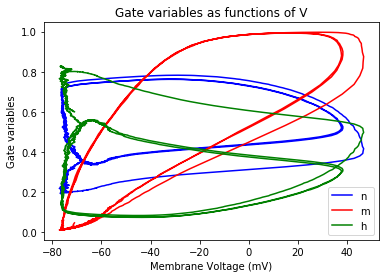

In [14]:
# plot n, m, h of v.
V = neuron.mon.V[:, 0]

plt.figure()
plt.plot(V, neuron.mon.n[:, 0], 'b', label='n')
plt.plot(V, neuron.mon.m[:, 0], 'r', label='m')
plt.plot(V, neuron.mon.h[:, 0], 'g', label='h')
plt.ylabel('Gate variables')
plt.xlabel("Membrane Voltage (mV)")
plt.title('Gate variables as functions of V')
plt.legend()

Because there are four state variables, visualizing the path in phase space can be difficult. The graph shows the limit cycles of voltage and each gating variable.

However, one must be careful because this is an ad-hoc method of visualizing the 4-dimensional system. This does not prove the existence of the limit cycle.

### Rate constants

$\alpha_x$ and $\beta_x$ represent the opening and closing rate of channel $x$, respectively. Now let's take a look at the change of rate constants as the voltage increases.

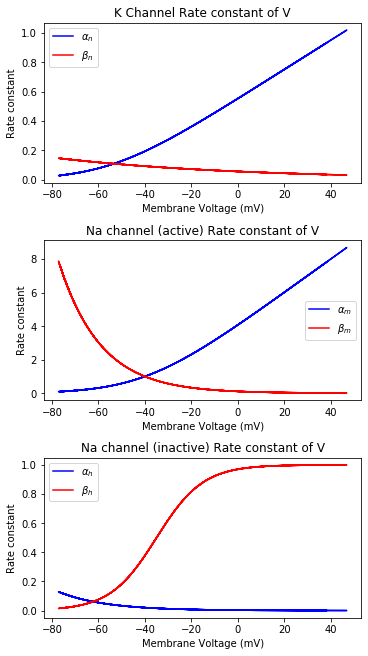

In [15]:
# plot alpha and beta values of v.
alpha_m = 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
beta_m = 4.0 * np.exp(-(V + 65) / 18)

alpha_h = 0.07 * np.exp(-(V + 65) / 20.)
beta_h = 1 / (1 + np.exp(-(V + 35) / 10))

alpha_n = 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
beta_n = 0.125 * np.exp(-(V + 65) / 80)

fig, gs = bp.visualize.get_figure(3, 1, 3, 5)

# plot n
fig.add_subplot(gs[0, 0])
plt.plot(V, alpha_n, 'b', label=r'$\alpha_n$')
plt.plot(V, beta_n, 'r', label=r'$\beta_n$')
plt.ylabel('Rate constant')
plt.xlabel("Membrane Voltage (mV)")
plt.title('K Channel Rate constant of V')
plt.legend()

# plot m
fig.add_subplot(gs[1, 0])
plt.plot(V, alpha_m, 'b', label=r'$\alpha_m$')
plt.plot(V, beta_m, 'r', label=r'$\beta_m$')
plt.ylabel('Rate constant')
plt.xlabel("Membrane Voltage (mV)")
plt.title('Na channel (active) Rate constant of V')
plt.legend()

# plot h
fig.add_subplot(gs[2, 0])
plt.plot(V, alpha_h, 'b', label=r'$\alpha_h$')
plt.plot(V, beta_h, 'r', label=r'$\beta_h$')
plt.ylabel('Rate constant')
plt.xlabel("Membrane Voltage (mV)")
plt.title('Na channel (inactive) Rate constant of V')
plt.legend()

The graphs show that $\alpha$ increases and $\beta$ decreases as the increment of voltage for $m$ ($Na^+$ active) and $n$ ($K^+$), which modulates the opening of ion channels.

While for $h$ ($Na^+$ inactive), the $\alpha$ decrease and $\beta$ increase as the increment of voltage, which modulates the closing of $Na^+$ channels.

### Steady values

A fixed point of gate variable of channel $x$, $x_\infty$, where the ion channels reach their steady state (equilibrium), is given by

$$ x_{\infty} = \frac {\alpha_x}{ \alpha_x + \beta_x} $$

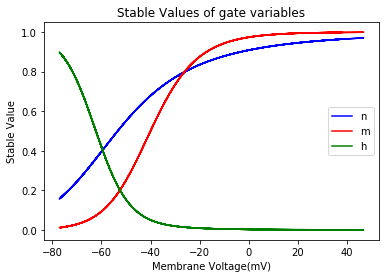

In [16]:
# plot limiting value of v.
plt.figure()
plt.plot(V, alpha_n/(alpha_n+beta_n), 'b', label='n')
plt.plot(V, alpha_m/(alpha_m+beta_m), 'r', label='m')
plt.plot(V, alpha_h/(alpha_h+beta_h), 'g', label='h')
plt.ylabel('Stable Value')
plt.xlabel("Membrane Voltage(mV)")
plt.title('Stable Values of gate variables')
plt.legend()

The graph represents that the steady values of $m$ ($Na^+$ active) and $n$ ($K^+$) increase as the increment of voltage, which reflects the opening of ion channels. While the decrement of $h$ ($Na^+$ inactive) indicates the closing of $Na^+$ channels during repolarization stage.

### Time constant

The time constant $\tau_x$ for the evolution of $x$ channel is given by

$$
\tau_x = {1 \over \alpha_x + \beta_x}
$$

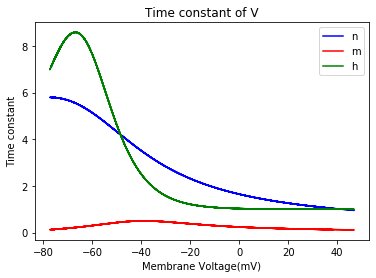

In [17]:
# plot time constant (tau) of v.

# compute tau
tau_m = 1/(alpha_m+beta_m)
tau_h = 1/(alpha_h+beta_h)
tau_n = 1/(alpha_n+beta_n)

# plot
plt.figure()
plt.plot(V, tau_n, 'b', label='n')
plt.plot(V, tau_m, 'r', label='m')
plt.plot(V, tau_h, 'g', label='h')
plt.ylabel('Time constant')
plt.xlabel("Membrane Voltage(mV)")
plt.title('Time constant of V')
plt.legend()

The time constant of $m$ is much smaller than $n$ and $h$ during resting potential, thus only $Na^+$ channel opens during the depolarization stage.

The time constants of $n$ and $h$ decrease as voltage increases, which represents the closing of $Na^+$ channel and opening of $K^+$ channel.

## Model Analysis

To see how the model respond to various input currents, let's start by defining a method to run simulation and visualize the dynamics.

In [18]:
def HH_simulate(input_current, duration, geometry = (1,), n_figs=2):
    '''
    Run simulation with HH model and visualize it.
    
    Args:
        input_current(NPArray).
        duration(float): duration of the input current.
        n_figs(int): number of figures to plot. Default 2 are Input current and membrane potential.
            3: plot gate variable.
            4: plot gate variable of V.
    '''

    if n_figs < 2:
        n_figs = 2
        print("n_figs must be >= 2!")
    
    # create HH neuron
    HH = define_HH(noise = 1.)
    
    # create HH HH_neuron
    HH_neuron = bp.NeuGroup(HH, geometry=geometry, monitors=['spike', 'V', 'm', 'h', 'n'])

    # set initial potential (between -55 and -75)
    HH_neuron.ST['V'] = np.random.random(geometry) * 20 + -75

    # apply input current to the HH_neuron
    HH_neuron.run(duration=duration, inputs=['ST.input', input_current], report=False)

    # read time sequence
    ts = HH_neuron.mon.ts
    fig, gs = bp.visualize.get_figure(n_figs, 1, 3, 6)
    
    V = HH_neuron.mon.V[:, 0]    
    
    # plot input current
    fig.add_subplot(gs[0, 0])
    try:
        plt.plot(ts, input_current, 'r')
    except:
        plt.plot(ts, input_current* np.zeros(len(ts)), 'r')
    else:
        pass
    plt.ylabel('Input Current')
    plt.xlim(-0.1, duration + 0.1)
    plt.xlabel('Time (ms)')
    plt.title('Input Current')
        
    # plot membrane potential
    fig.add_subplot(gs[1, 0])
    plt.plot(ts, V)
    plt.ylabel('Membrane potential')
    plt.xlim(-0.1, duration + 0.1)
    plt.ylim(-95., 60.)
    plt.title('Membrane potential')
    
    if n_figs > 2:
        # plot gate variables
        fig.add_subplot(gs[2, 0])
        plt.plot(ts, HH_neuron.mon.m[:, 0], label='Na active (m)')
        plt.plot(ts, HH_neuron.mon.h[:, 0], label='Na inactive (h)')
        plt.plot(ts, HH_neuron.mon.n[:, 0], label='K (n)')
        plt.legend()
        plt.xlim(-0.1, duration + 0.1)
        plt.xlabel('Time (ms)')
        plt.ylabel('gate variables')
        plt.title('gate variables')
        
        if n_figs > 3:
            # plot n, m, h of v.
            fig.add_subplot(gs[3, 0])
            plt.plot(V, HH_neuron.mon.n[:, 0], 'b', label='n')
            plt.plot(V, HH_neuron.mon.m[:, 0], 'r', label='m')
            plt.plot(V, HH_neuron.mon.h[:, 0], 'g', label='h')
            plt.ylabel('Gate variables')
            plt.xlabel("Membrane Voltage(mV)")
            plt.title('Gate variables of V')
            plt.legend()

### Find critical current

Let's determine the lowest step current amplitude $I_{min}$ for generating at least one spike by trying different input amplitudes. (The duration of step current is 5 ms.)

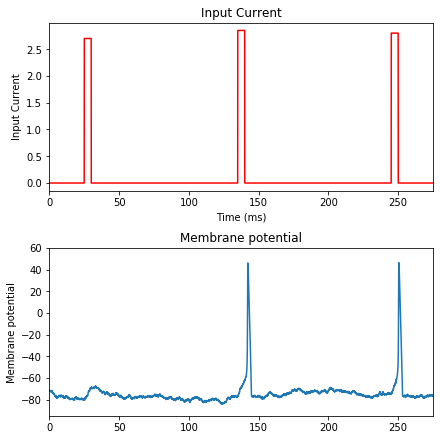

In [27]:
# apply several step currents
amplitudes = [2.7, 0, 2.85, 0, 2.8]  # step current amplitude

stim_interval = 25.
stim_dur = 5.   # stimulation duration
I = []

for amplitude in amplitudes:
    I.append((0., stim_interval))
    I.append((amplitude, stim_dur))
    I.append((0., stim_interval))
    
(step_I, duration) = bp.inputs.constant_current(I)

# run simulation
HH_simulate(input_current=step_I, duration=duration, geometry = (10,))

It seems that $I_{min}$ is between 2.7 and 2.85.

#### Minimal current to generate repetitive firing

We can use the same way to determine the lowest step current amplitude to generate repetitive firing.

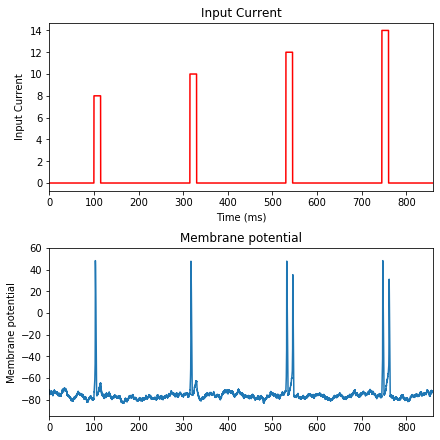

In [20]:
# apply several step currents
amplitudes = [8., 10., 12., 14.]  # step current amplitude

stim_interval = 100.
stim_dur = 15.   # stimulation duration
I = []

for amplitude in amplitudes:
    I.append((0., stim_interval))
    I.append((amplitude, stim_dur))
    I.append((0., stim_interval))
    
(step_I, duration) = bp.inputs.constant_current(I)

# run simulation
HH_simulate(input_current=step_I, duration=duration)

It seems that $I_{min}$ is between 12 and 14.

### Slow ramp current response

Now let's inject a slow ramp current into a HH neuron and find the lowest amplitude that can elicit a spike.

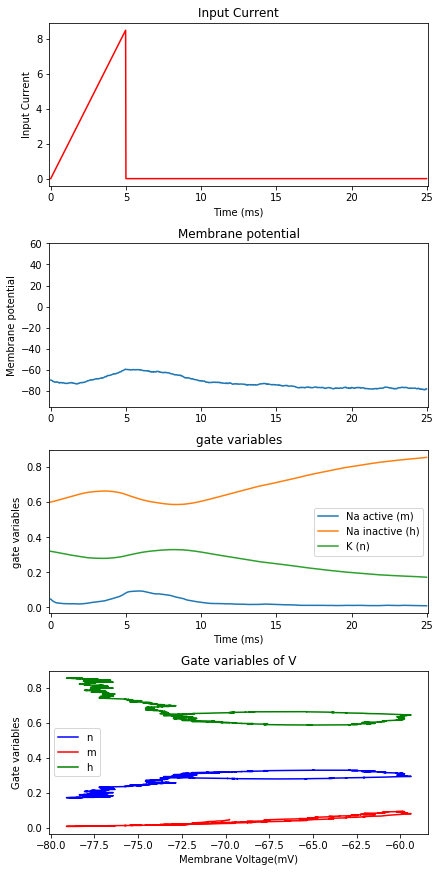

In [21]:
# apply slow ramp current
c_duration = 5.
duration = 20. + c_duration

ramp_I = bp.inputs.ramp_current(c_start = 0., 
                                c_end = 8.48, 
                                duration = duration,
                                t_end = c_duration)

# run simulation
HH_simulate(input_current=ramp_I, duration=duration, n_figs=4)

### Fast ramp current response

Now inject a fast ramp current and find it's critical amplitude.

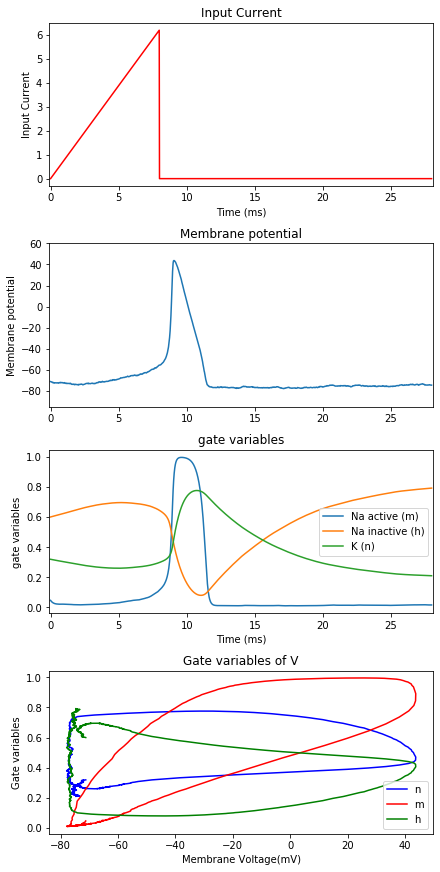

In [22]:
# apply fast ramp current
c_duration = 8.
duration = 20. + c_duration

ramp_I = bp.inputs.ramp_current(c_start = 0., 
                                c_end = 6.2, 
                                duration = duration,
                                t_end = c_duration)

# run simulation
HH_simulate(input_current=ramp_I, duration=duration, n_figs=4)

### Rebound spike

A HH neuron can spike not only if it receives a sufficiently strong depolarizing input current but also after a hyperpolarizing current. Such a spike is called a rebound spike.

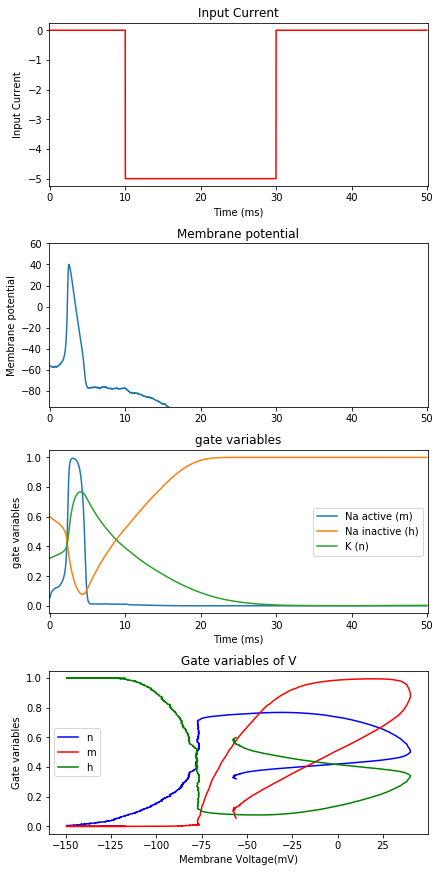

In [23]:
# apply rebound spike
# step current parameters
amplitude = -5.  # step current amplitude
duration = 50.  # total duration of the simulation
stim_start = 10. # stimulation start time
stim_dur = 20.   # stimulation duration

# generate step current
I = [(0, stim_start), (amplitude, stim_dur), (0, duration-stim_dur-stim_start)]
(step_I, duration) = bp.inputs.constant_current(I)

# run simulation
HH_simulate(input_current=step_I, duration=duration, geometry = (10,), n_figs=4)

Now let's try a weaker hyperpolarizing current with `amplitude = -1` and see what happen.

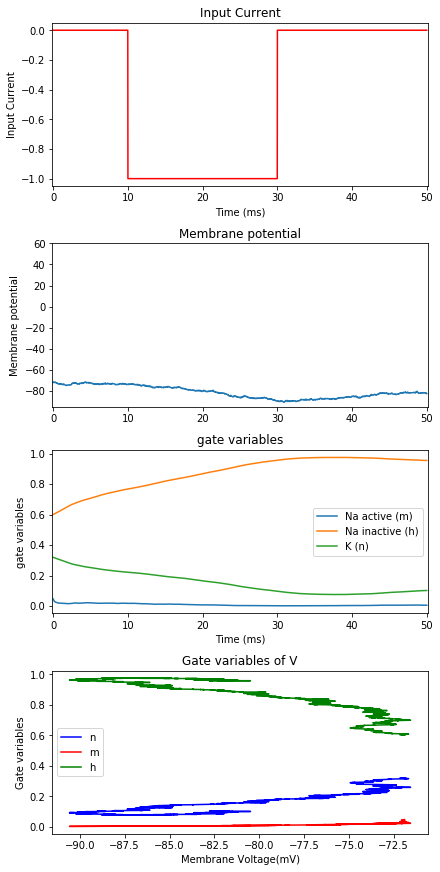

In [24]:
# apply rebound spike
# step current parameters
amplitude = -1.  # step current amplitude
duration = 50.  # total duration of the simulation
stim_start = 10. # stimulation start time
stim_dur = 20.   # stimulation duration

# generate step current
I = [(0, stim_start), (amplitude, stim_dur), (0, duration-stim_dur-stim_start)]
(step_I, duration) = bp.inputs.constant_current(I)

# run simulation
HH_simulate(input_current=step_I, duration=duration, geometry = (10,), n_figs=4)

The graphs show that there is no spike.

### No input

Run a simulation with no input current to determine the resting potential of the neuron. 

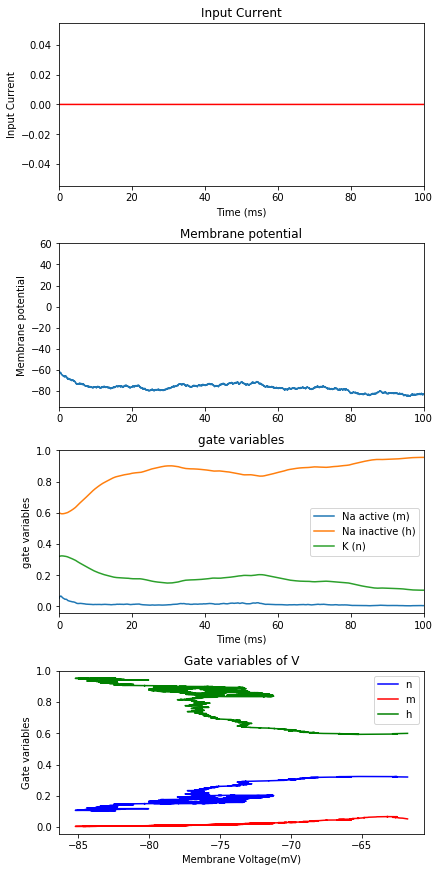

In [25]:
# run simulation
HH_simulate(input_current=0., duration=100, n_figs=4)